In [414]:
import datetime, urllib, re, math, json, requests
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML



try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

In [415]:
#* constants



#** pandas
# change max number of rows to show
pd.set_option('display.max_rows', 300)

#** plotters formats

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cycler import cycler
#* dpi size
plt.rcParams['figure.dpi'] = 200
myFmt = mdates.DateFormatter('%m/%d')
myLocator = mticker.MultipleLocator(7)

default_cycler = (cycler(marker=['.','*','+','s','x']) *
                  cycler(color=['b','g','k','m','y','c','r']) *
                  cycler(linestyle=['-']))

plt.rc('axes', prop_cycle=default_cycler)

# real time data, from a spin of JHU
http://blog.lazd.net/coronadatascraper/

In [416]:
df = pd.read_csv("http://blog.lazd.net/coronadatascraper/data.csv",parse_dates=True)
dataCS =df.set_index(["city","county","state","country"])


#use index slice for more easy/clean access
idx = pd.IndexSlice

IClmns= idx["cases","death","recovered","tested",'url']


ctrMask = dataCS["cases"] > 1000
dataCS.loc[idx[:,:, :, ctrMask],:]

cases  deaths  recovered  tested  \
city county state               country                                     
NaN  NaN    NaN                 DEU       7272    17.0       67.0     NaN   
                                ITA      27980  2158.0     2749.0     NaN   
                                SWE       1103     6.0        1.0     NaN   
                                BEL       1058     5.0        1.0     NaN   
                                CHE       2200    14.0        4.0     NaN   
                                AUT       1018     3.0        6.0     NaN   
                                NOR       1333     3.0        1.0     NaN   
            Hubei               CHN      67798  3099.0    55142.0     NaN   
            NaN                 IRN      14991   853.0     4590.0     NaN   
                                KOR       8236    75.0     1137.0     NaN   
            Guangdong           CHN       1361     8.0     1306.0     NaN   
            Henan               CHN       1273    22.0     1250.0     NaN   
            Zhejiang            CHN       1231     1.0     1216.0     NaN   
            Hunan               CHN       1018     4.0     1014.0     NaN   
            NaN                 GBR       1543    55.0       20.0     NaN   
            Emilia Romagna      ITA       3522   346.0       88.0     NaN   
            Lombardia           ITA      14649  1420.0     2368.0     NaN   
            Marche              ITA       1242    57.0        0.0     NaN   
            Piemonte            ITA       1516   111.0        0.0     NaN   
            Veneto              ITA       2473    69.0      130.0     NaN   
            Ile-de-France       FRA       1762     0.0        NaN     NaN   
            Grand Est           FRA       1543     0.0        NaN     NaN   
            NaN                 FRA       6633     NaN        NaN     NaN   
            Comunidad de Madrid ESP       4165   213.0        0.0     NaN   
            NaN                 ESP       9191   309.0        2.0     NaN   

                                         active   population        lat  \
city county state               country                                   
NaN  NaN    NaN                 DEU        7188   80594017.0  51.099245   
                                ITA       23073   62137802.0  41.826062   
                                SWE        1096    9960487.0  62.191185   
                                BEL        1052   11491346.0  50.490421   
                                CHE        2182    8236303.0  46.840811   
                                AUT        1009    8754413.0  47.713135   
                                NOR        1329    5320045.0  69.255255   
            Hubei               CHN        9557   59170000.0  31.166405   
            NaN                 IRN        9548   82021564.0  32.412651   
                                KOR        7024   51181299.0  35.912360   
            Guangdong           CHN          47  113460000.0  22.876784   
            Henan               CHN           1   96050000.0  33.877080   
            Zhejiang            CHN          14   57370000.0  29.189050   
            Hunan               CHN           0   68990000.0  27.369415   
            NaN                 GBR        1468   64769452.0  55.191616   
            Emilia Romagna      ITA        3088    4459477.0  44.435519   
            Lombardia           ITA       10861   10060574.0  45.657567   
            Marche              ITA        1185    1525271.0  43.327896   
            Piemonte            ITA        1405    4356406.0  45.261022   
            Veneto              ITA        2274    4905854.0  45.737147   
            Ile-de-France       FRA        1762          NaN        NaN   
            Grand Est           FRA        1543          NaN        NaN   
            NaN                 FRA        6633   67106161.0  14.862001   
            Comunidad de Madrid ESP        3952          NaN        NaN   
           

In [431]:
idx = pd.IndexSlice

# must have colons liberally used, firt two colons for city/county and last colon for all columns
#option 1 for access
dataCS.loc[(np.nan, "Los Angeles County", "CA", "USA")]
#option 2 for access, using idx must have colons liberally used, firt two colons for city/county and last colon for all columns
dataCS.loc[idx[:, "San Diego County", "CA", "USA"],IClmns]
#total cases in ca
dataCS.loc[idx[np.nan, np.nan, "CA", "USA"],:]["cases"]
display(HTML(dataCS.loc[idx[:, :, "CA", "USA"],IClmns].to_html()))

dataCS.loc[idx[:, "San Diego County", "CA", "USA"],["url"]].values

array([['https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html']],
      dtype=object)

# CDC Data is here:

html --> https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html    
json --> https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json

In [418]:
#using cdc data direclty for the US


url = "https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json"

r = requests.get(url)
jdata =r.json()

# get x/y's
x = jdata["data"]["columns"][0][1:]
X = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in x] # x's
v = jdata["data"]["columns"][1][1:] # v's (new cases fo the day)

# interpolate the zeros, since nearly impossible to have no growth
V = pd.Series(np.array(v).astype('int'))
V[V==0]=np.nan #
V = V.interpolate()
if(0): #check data
    print(list(zip(X,V)))
# Remove fist zeros
offsetZero = V.notna().idxmax()
V = V.values[offsetZero:]
X = X[offsetZero:]    

# convert new cases (v) to cumulative cases(y)
dataCdc = pd.Series(V,X).cumsum()



# john hopkins data base
## gui 

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

## githunb 

https://github.com/CSSEGISandData/COVID-19

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series

In [419]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids, set Na for np.NaN (very annoying)
df["Province/State"]=df["Province/State"].fillna("NA")
df =df.set_index(["Country/Region","Lat","Long","Province/State"])


df.columns = pd.to_datetime(df.columns,format="%m/%d/%y")

dt = df.columns[-1]
print(dt)
if sum(df[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data = df.drop(columns=dt)
else:
    data = df
#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
euro      = ["Germany","DenMark","France","Italy","Sweden","Switzerland",
             "Spain","Portugal","Belgium","Iceland","Ireland","Netherlands"]
print(noChin)
data.loc["NoChina",np.NaN,np.NaN,"NA"]=data.loc[(noChin)].sum()    
data.loc[("Europe",np.NaN,np.NaN,"NA")]=data.loc[euro].sum()    
# note this is an over-estimate
data.loc[("USAll",np.NaN,np.NaN,"NA")]=data.loc["US"].sum()    

data.loc[("ChinaAll",np.NaN,np.NaN,"NA")]=data.loc["China"].sum()  



2020-03-16 00:00:00
Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       ...
       'Turkey', 'US', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'occupied Palestinian territory'],
      dtype='object', name='Country/Region', length=155)


In [420]:
# create new groups
# dont use string for UR, but the 50 states

northAmer = ["US","Canada","Mexico"],
asia      = ["South Korea","Taiwan","Japan"]   
middleEast=["Iraq","Egypt","Iran"]
countries={ "NoChina":"NoChina",
            "North America":northAmer,
            "Europe":"Europe",            
            "middle east":middleEast,
            "China":"China",
            "South Korea":"South Korea",
            "Japan":"Japan",
            "Italy":"Italy",            
            "South Korea":"Korea, South",
            "US":"US"}


In [452]:
# find rows with NA for province/state
g =data.filter(like="NA",axis=0)
# find countries with large case counts
g=g.loc[(g[dt]>1500)]

#g = g.loc[(g[dt]>1000),(data.columns[-1],data.columns[-2])]
#d = pd.DataFrame(g.loc[:,(data.columns[-1])]-g.loc[:,data.columns[-2]],columns=["delta"])
#display_side_by_side(g,d)
dataFocus = pd.DataFrame()
dataFocus[data.columns[-1]] = g.loc[(g[dt]),(data.columns[-1])]
dataFocus[data.columns[-2]] = g.loc[(g[dt]),(data.columns[-2])]
dataFocus["delta"]          = g.loc[:,(data.columns[-1])]-g.loc[:,data.columns[-2]]
display(HTML(dataFocus.sort_values(by="delta",ascending=False).to_html()))


# create list of countires to focus on for later processing
countriesFocused = [data.index.levels[0][i] for i in g.index.labels[0]]
data[data[dt]>1500]
countriesFocused = countriesFocused+["France","United Kingdom"]


,,,,2020-03-16 00:00:00,2020-03-15 00:00:00,delta
Country/Region,Lat,Long,Province/State,,,
NoChina,NaN,NaN,NA,NaN,NaN,14067
Europe,NaN,NaN,NA,NaN,NaN,9657
Italy,43.0000,12.0000,NA,NaN,NaN,3233
Spain,40.0000,-4.0000,NA,NaN,NaN,2144
Germany,51.0000,9.0000,NA,NaN,NaN,1477
USAll,NaN,NaN,NA,NaN,NaN,1133
Iran,32.0000,53.0000,NA,NaN,NaN,1053
"Korea, South",36.0000,128.0000,NA,NaN,NaN,74
ChinaAll,NaN,NaN,NA,NaN,NaN,30


Growth Rate NoChina:1.15
Growth Rate China:1.06
Growth Rate Korea, South:1.11
Growth Rate Europe:1.18


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\scimath.py:310: RuntimeWarning: divide by zero encountered in log10
  return nx.log10(x)


<Figure size 1200x800 with 0 Axes>

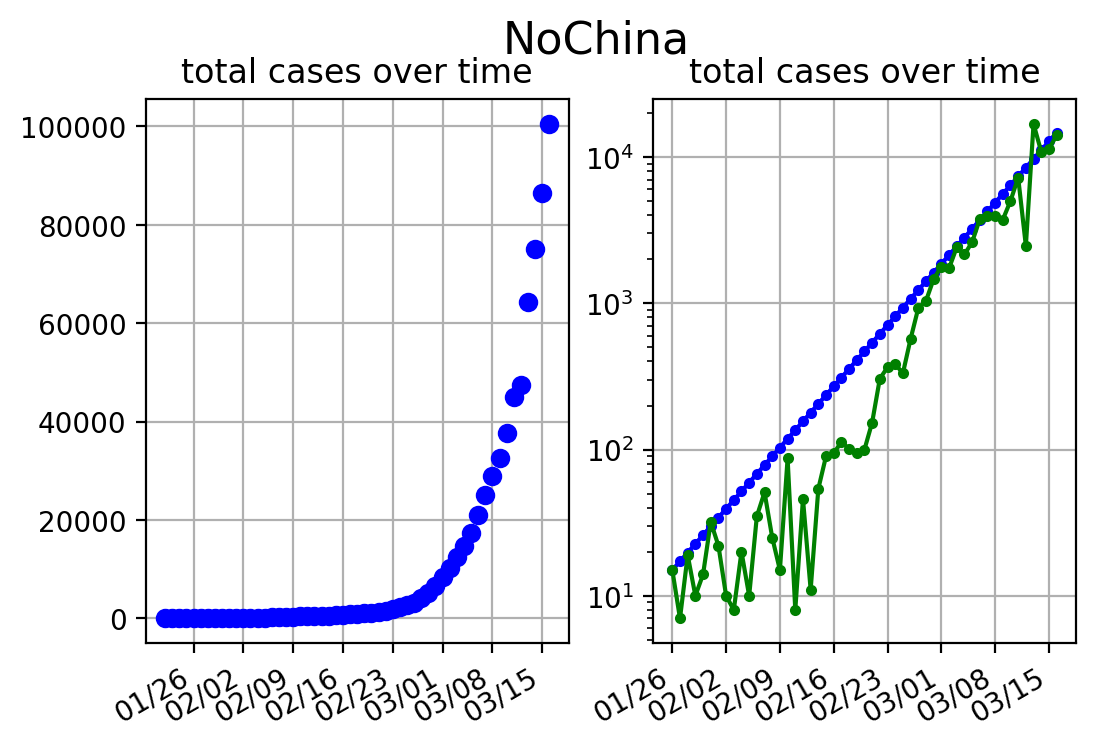

<Figure size 1200x800 with 0 Axes>

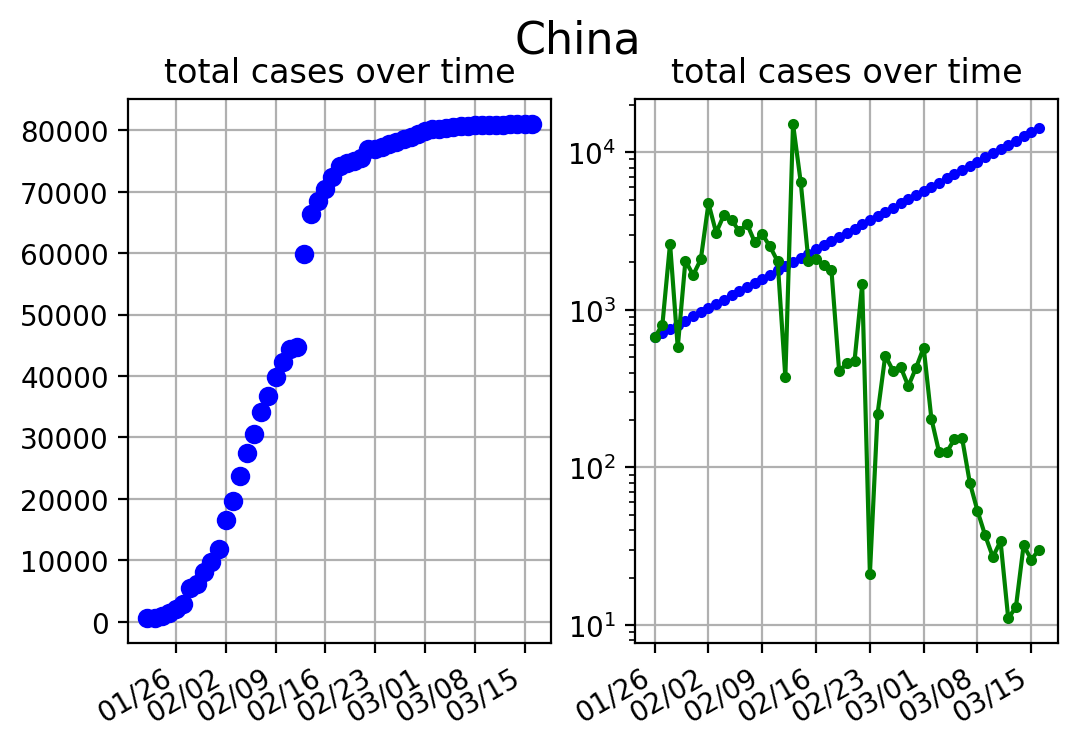

<Figure size 1200x800 with 0 Axes>

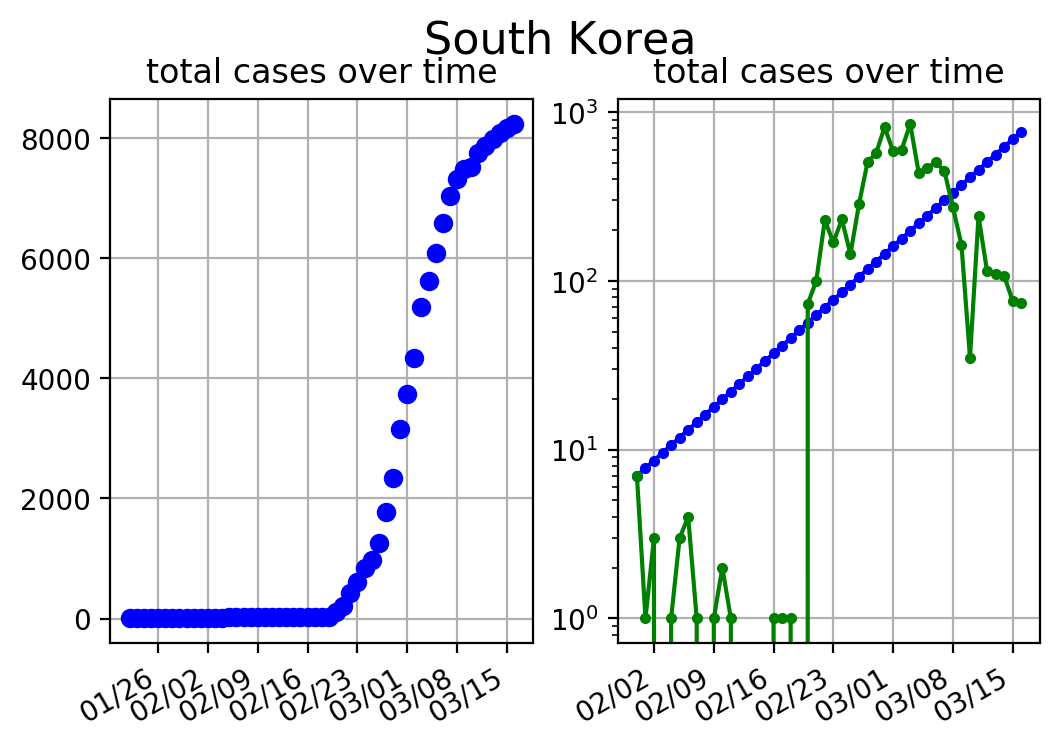

<Figure size 1200x800 with 0 Axes>

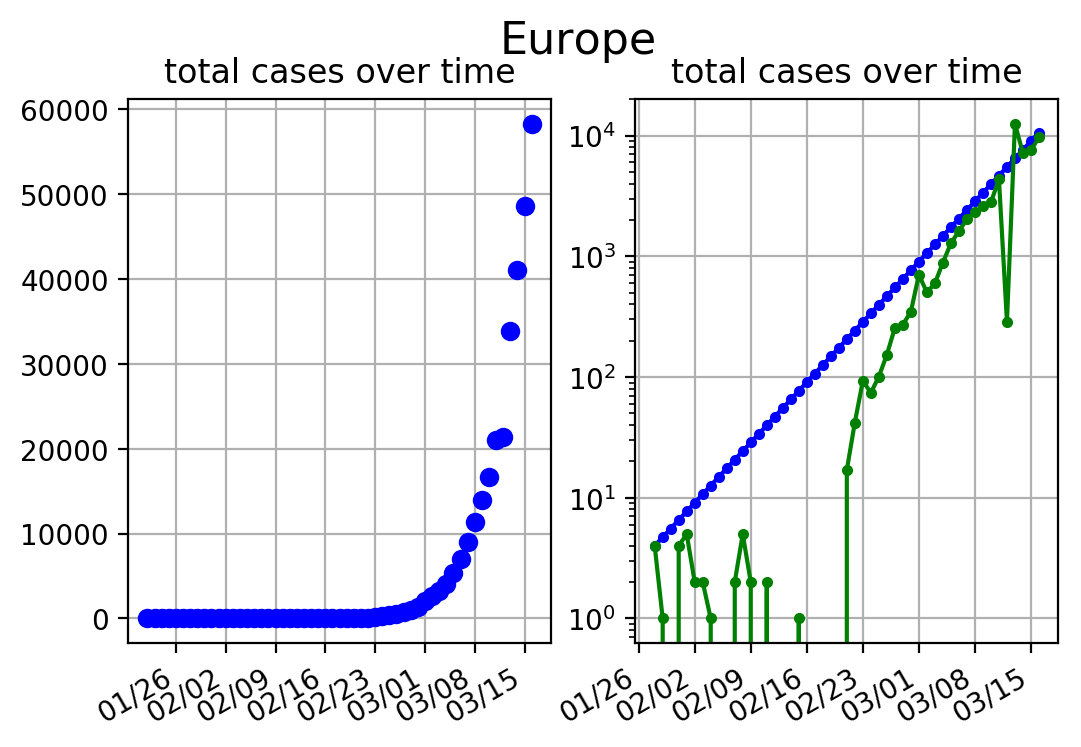

In [422]:
#assume (1+E*P) is 120%


#determine slope and plot
for name in ["NoChina","China", "South Korea", "Europe"]:
    ctr = countries[name]
    plt.figure()
    vals= data.loc[ctr].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    #print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(max(lv)-lv[0])/(sp.size(lv))

    print("Growth Rate %s:%.2f"%(ctr,math.pow(10,m)))
    #print()
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    ax[1].grid()
#    ax[1].legend()
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].set_title("total cases over time");

    fig.autofmt_xdate()
    
    #---
    y=data.loc[ctr].sum()
    ax[0].plot_date(y.index,y.values)        
    ax[0].grid()
#    ax[0].legend()
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].set_title("total cases over time");

    fig.autofmt_xdate()
    
    fig.suptitle('%s'% name, fontsize=16)


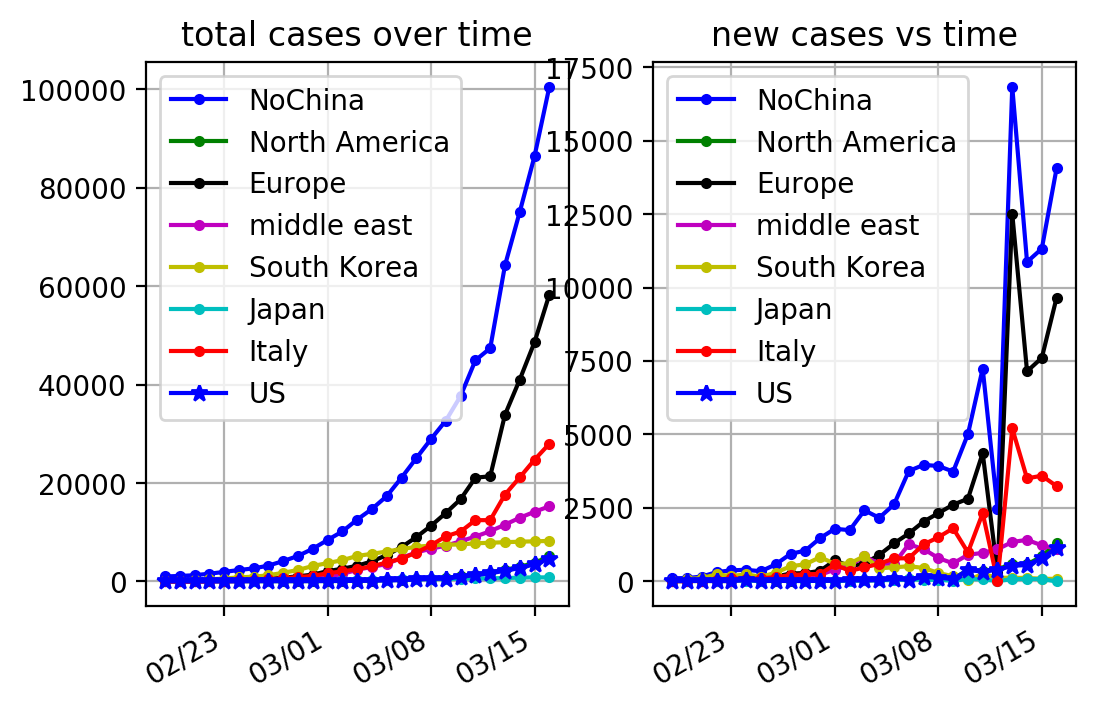

In [453]:
offset=28
#ignore china here
fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    y = data.loc[(country)].sum()
    ax[0].plot(y.index[offset:],y.values[offset:],label=name)
#ax[0].xaxis.set_major_locator(myLocator)
ax[0].grid()
ax[0].legend()
ax[0].xaxis.set_major_locator(myLocator)
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    ax[1].plot(vals[offset:],label=name)
ax[1].xaxis.set_major_locator(myLocator)
ax[1].grid()
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].legend()
ax[1].set_title("new cases vs time");

fig.autofmt_xdate()



# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

[ The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far. ]


A3date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1200x800 with 0 Axes>

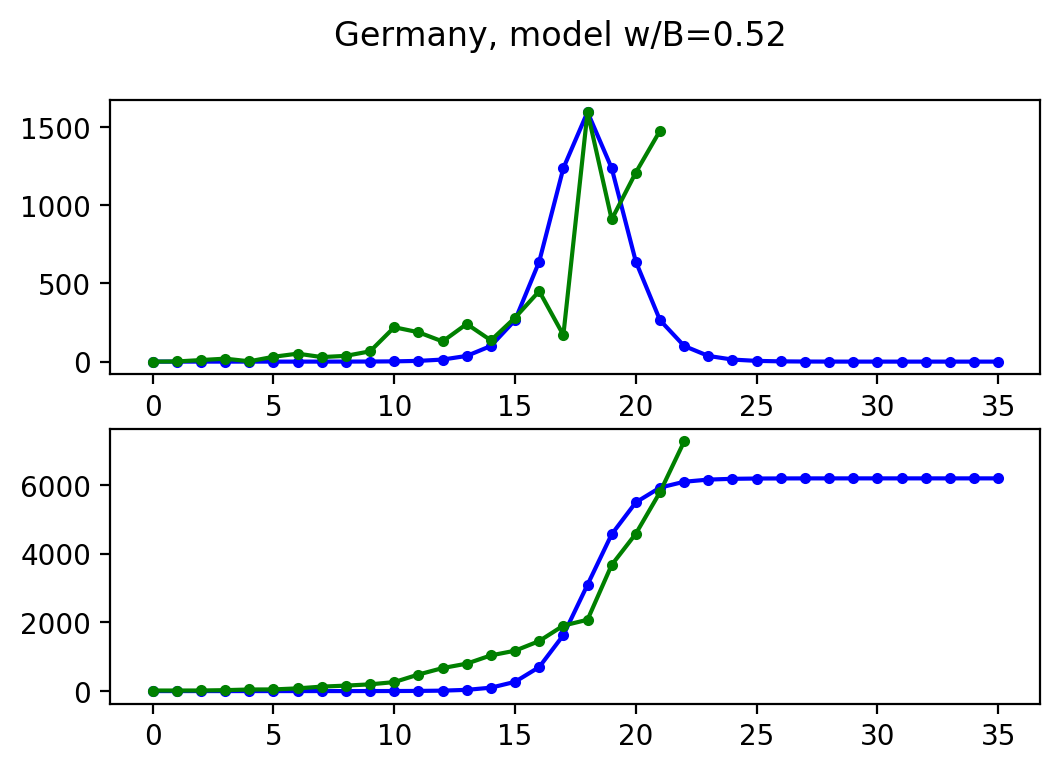

<Figure size 1200x800 with 0 Axes>

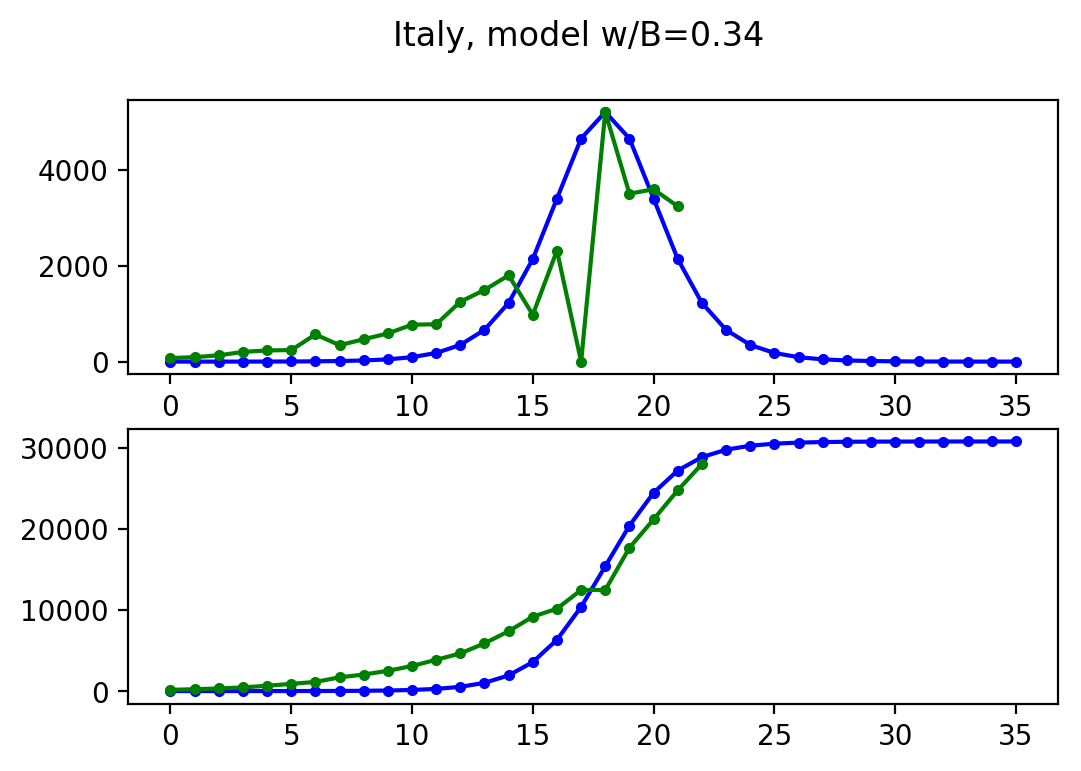

<Figure size 1200x800 with 0 Axes>

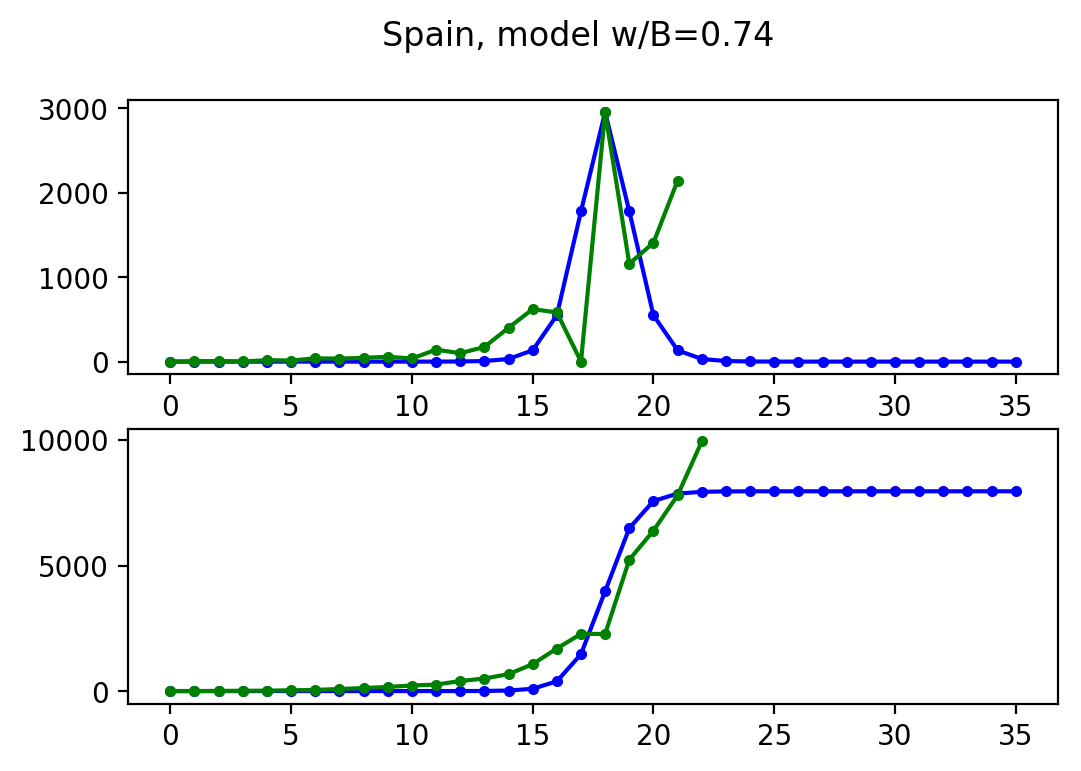

<Figure size 1200x800 with 0 Axes>

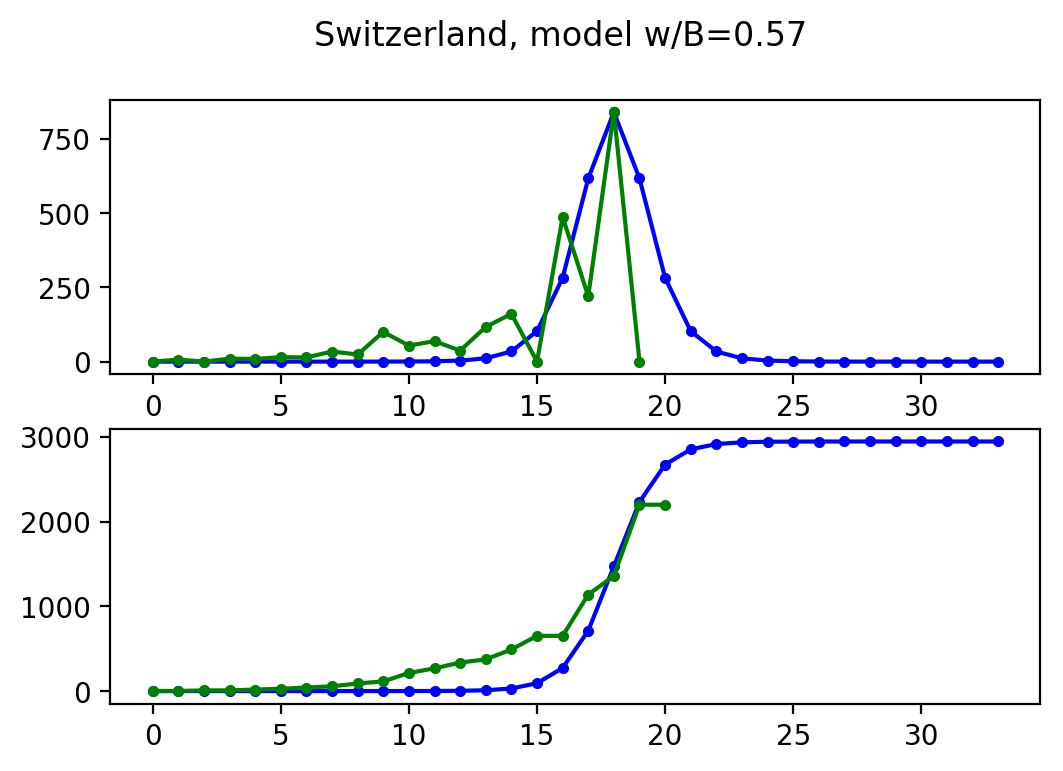

<Figure size 1200x800 with 0 Axes>

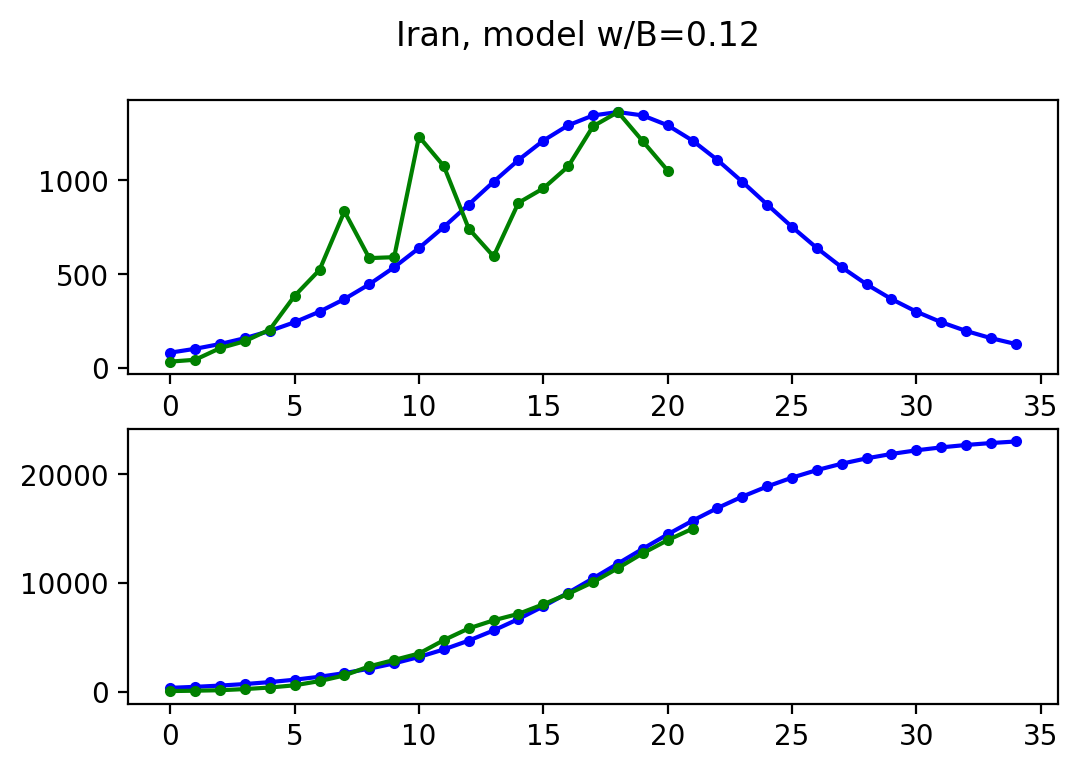

<Figure size 1200x800 with 0 Axes>

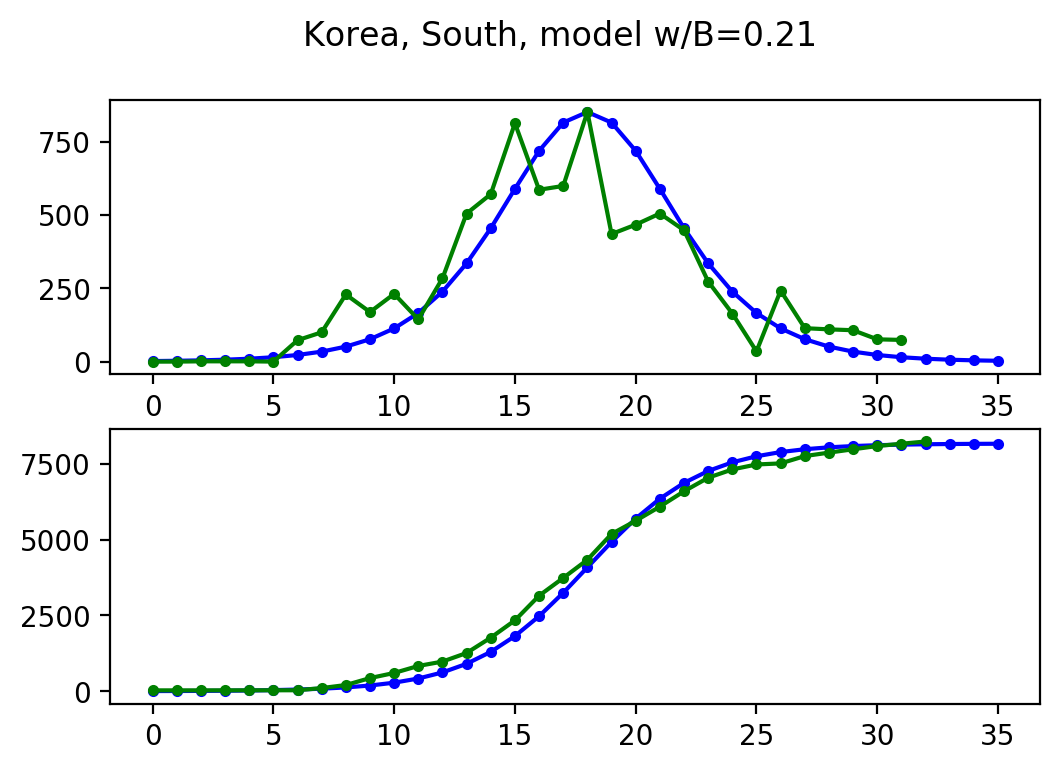

<Figure size 1200x800 with 0 Axes>

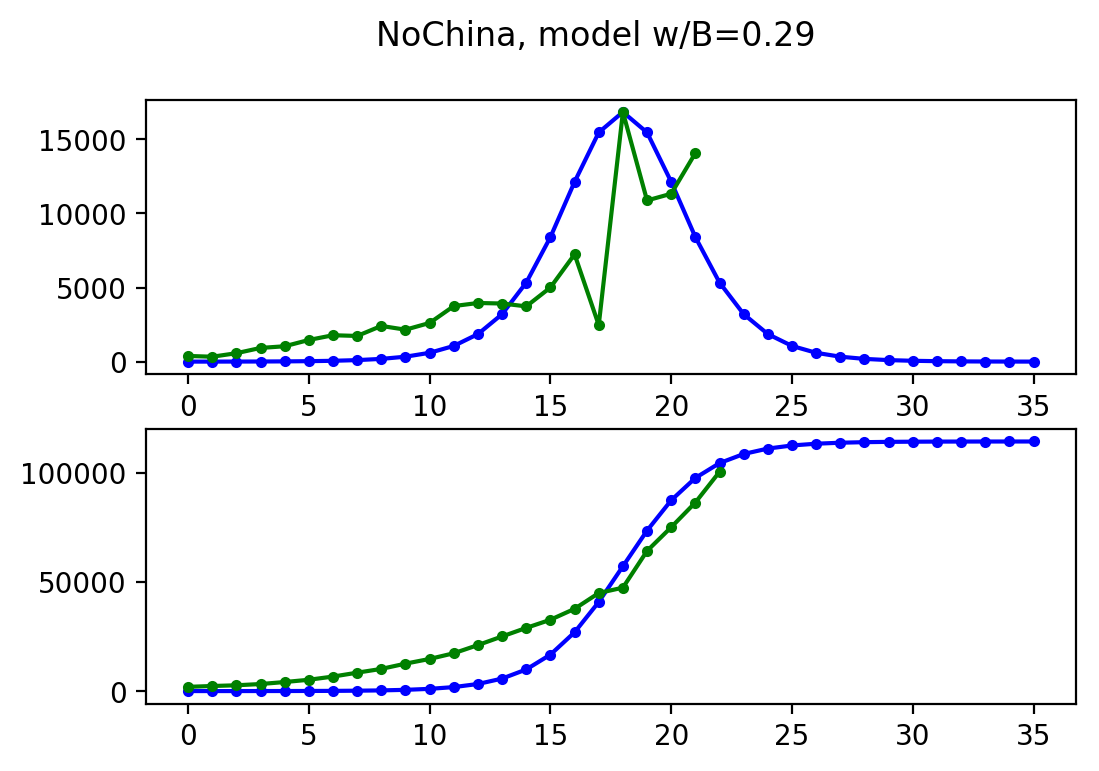

<Figure size 1200x800 with 0 Axes>

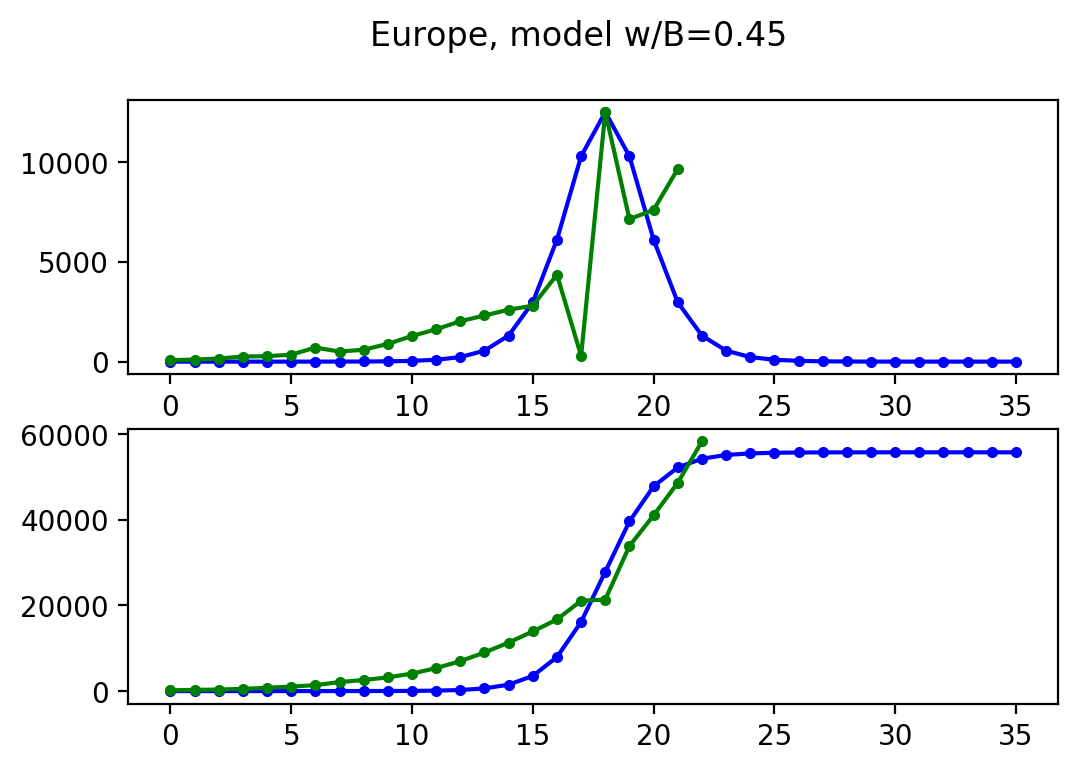

<Figure size 1200x800 with 0 Axes>

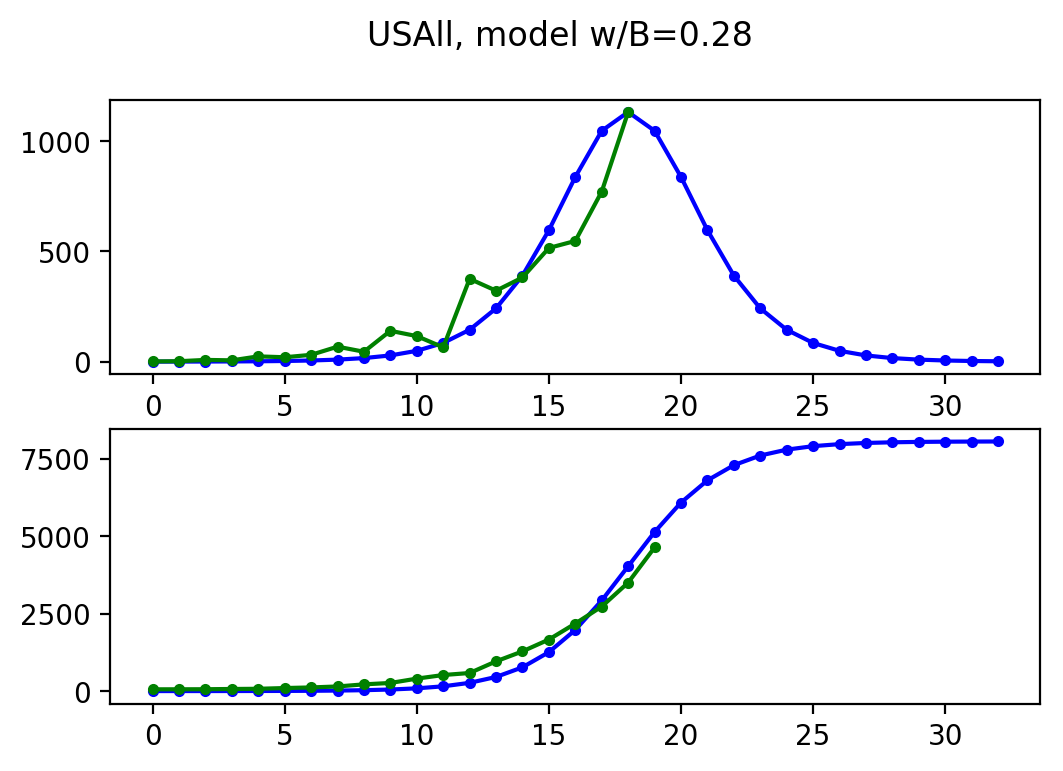

<Figure size 1200x800 with 0 Axes>

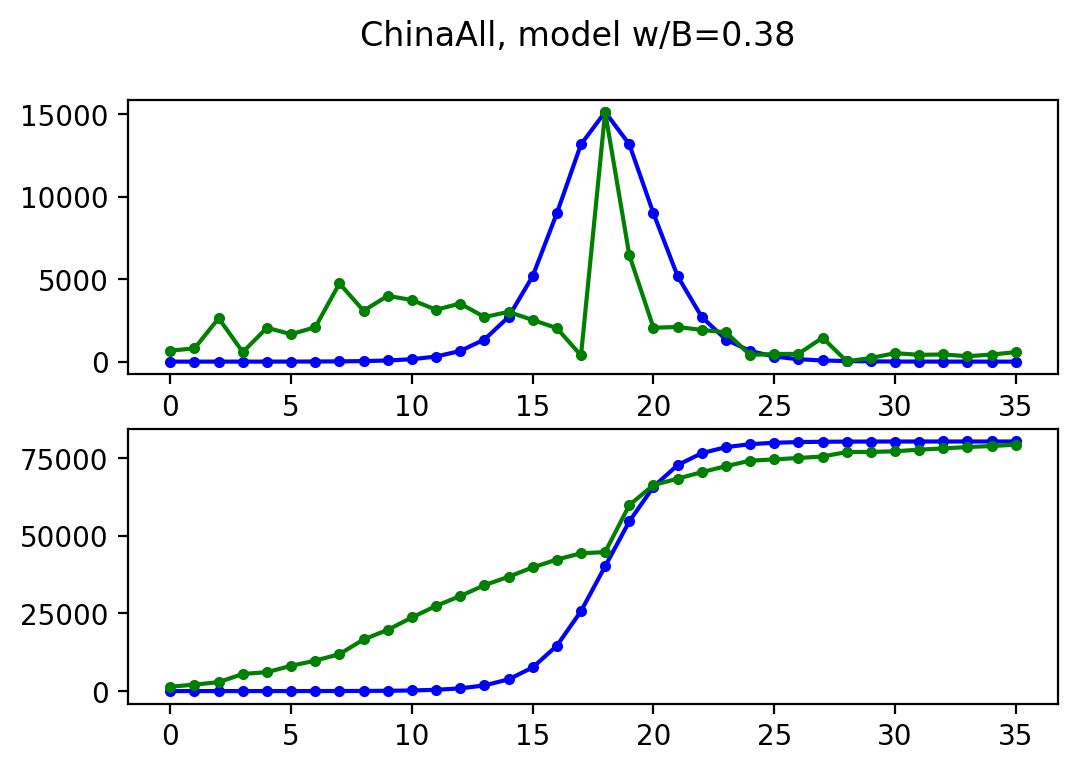

<Figure size 1200x800 with 0 Axes>

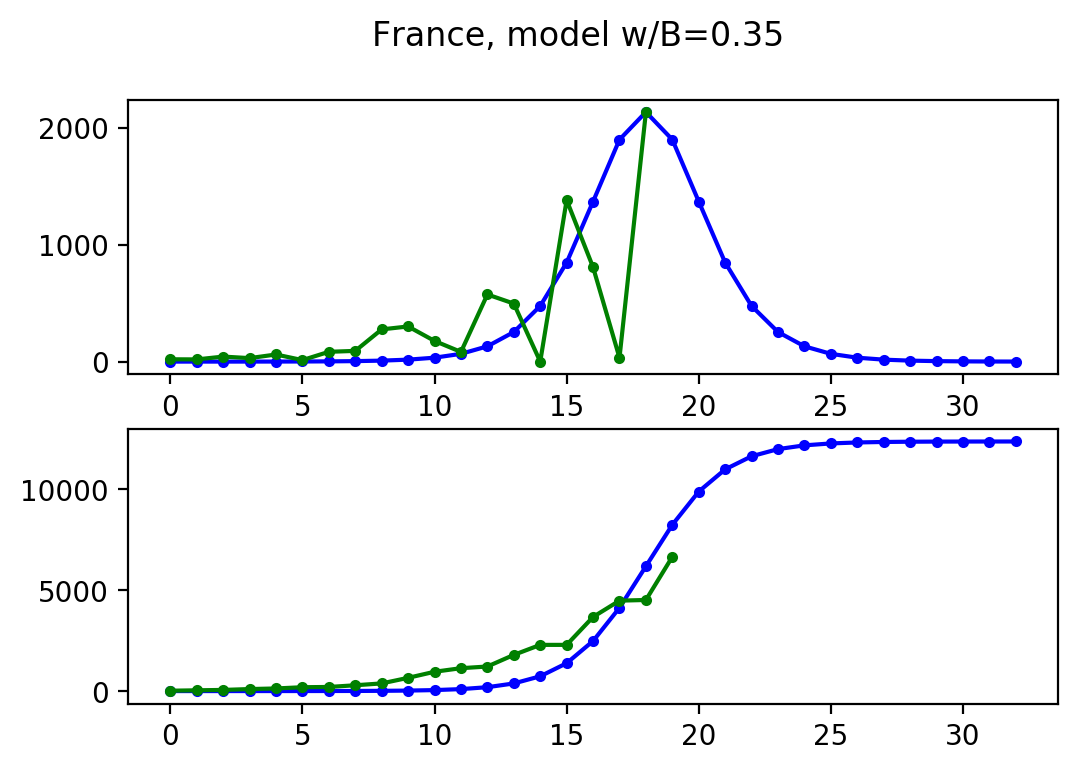

<Figure size 1200x800 with 0 Axes>

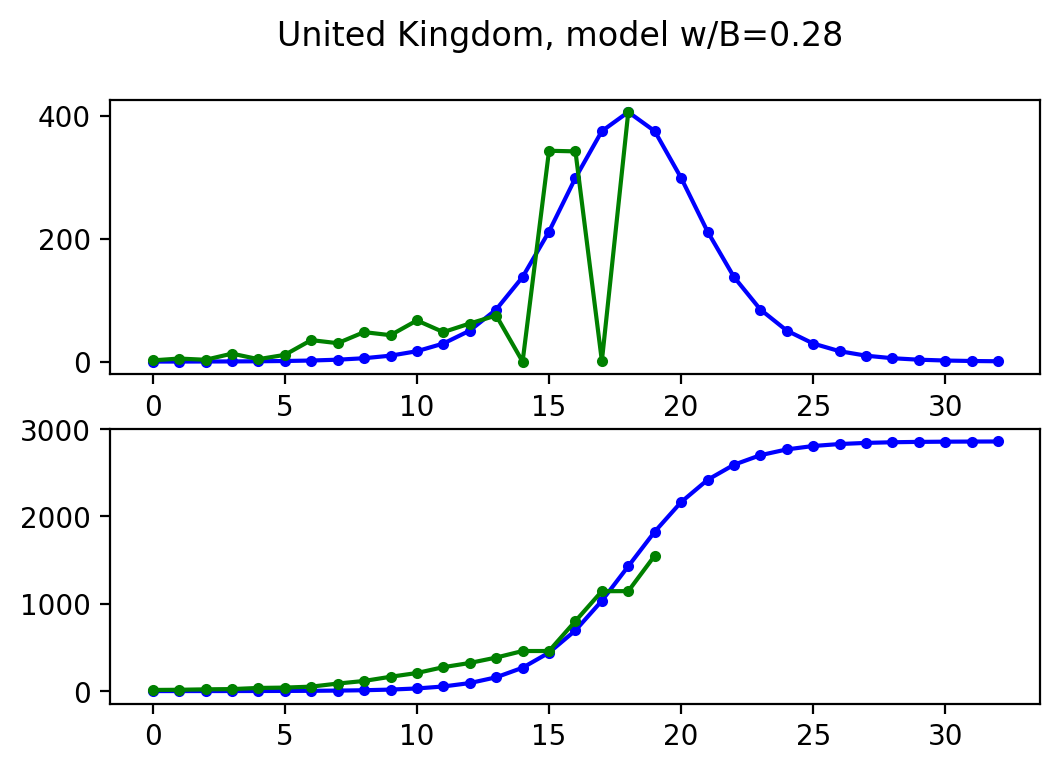

In [454]:
# place a model on all countries with high counts

for ctr in countriesFocused:
    plt.figure()
    # get daily change, drop first value, '0'
    v = data.loc[ctr].sum().diff().values[1:]
    y = data.loc[ctr].sum().values
    
    #A/C are derived, 
    A=max(v)
    C=np.argmax(v)
    # this is width variable, smaller means slower groth (this is a guss)
    # first run wiht a good set then adjust to target (for example run with south kora)
    def model(t,A,C,B):    
        return A/B * ( np.tanh( B * (t-C)) + 1 )
    f = lambda t,B: model(t, A, C,B)
    t = np.arange(0,sp.size(y))
    params, params_covariance = optimize.curve_fit(f, t, y,
                                               p0=[.2])
    
    B=params[0]
     
    #number of samples to plot is inversely releated to B
    M = 18# 2.5 weeks

    # must be in days
    N=sp.size(v)
    t = np.arange(0,N+14)
    yh = A/B * ( np.tanh( B * (t-C)) + 1 )

    vh = A/(np.cosh( B * (t-C))**2)
    fig, ax = plt.subplots(2,1,)
    label="%s, model w/B=%.2f" % (ctr,B)
    ax[0].plot(vh[C-M:C+M])
    ax[0].plot(v[C-M:C+M])
    fig.suptitle(label)
    ax[1].grid()
    ax[1].plot(yh[C-M:C+M])
    
    ax[1].plot(y[C-M:C+M])
    
    ax[1].grid()



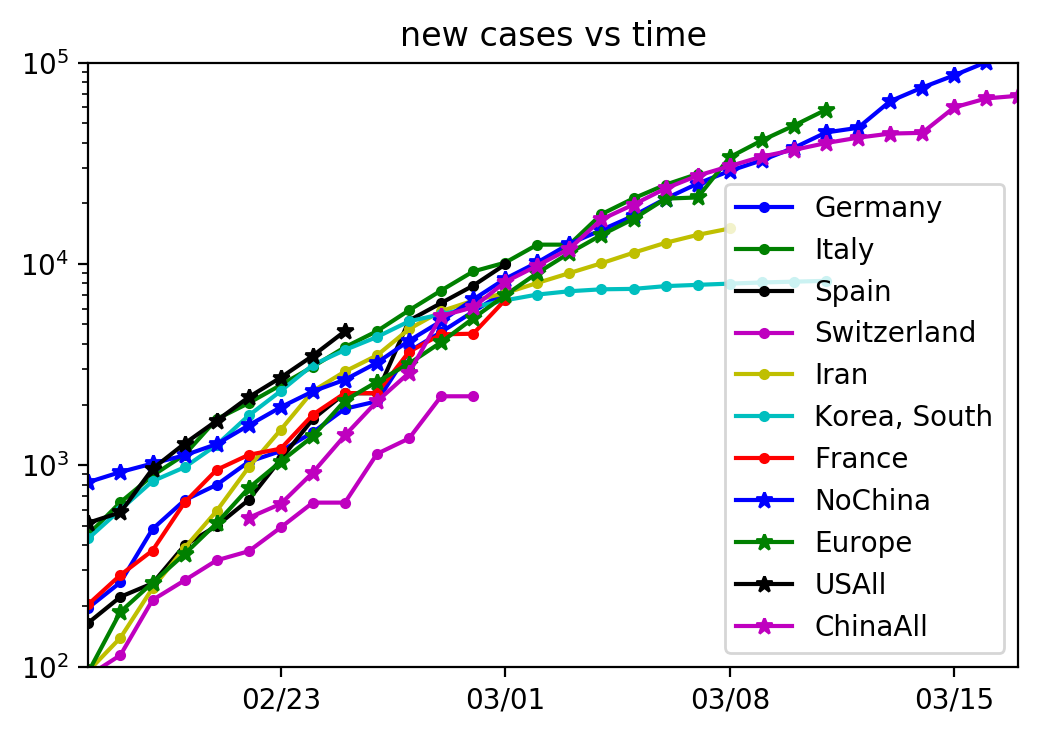

In [455]:
#align countries, with the following offset to get a prediction where they are 
# ideally normalize too

offsets = {"ChinaAll":31,
           "Italy":-9,
           "Spain":-15,
           "Iran":-8,
           "Germany":-15,
           "Korea, South":-5,
           "Switzerland":-16,
           "France":-15,
           "NoChina":0,
           "Europe":-5,
           "Norway":-20,
           "United Kingdom":-20,
           "USAll":-20}


                  


#plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'rgbcmyk') +"
#                                   "cycler('lw', [1, 1, 3])")
                  
fig, ax=plt.subplots(1,1)
for index, row in data[data[dt]>2000].iterrows():
    ctr =index[0]
    #print(ctr)
    if("China" == ctr): continue
    
    vdt = [(d +datetime.timedelta(days=offsets[ctr])).date()#.strftime("%m/%d")
           for d in data.columns]
    
    ax.semilogy(vdt,row.values, label=ctr)
#ax.xaxis.set_major_locator(myLocator)
ax.grid()
#control range to zoom regio of interest
ax.set_ylim(1e2, 1e5)
ax.set_xlim(datetime.date(2020, 2, 17), datetime.date.today())
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("new cases vs time");



2020-02-08 00:00:00


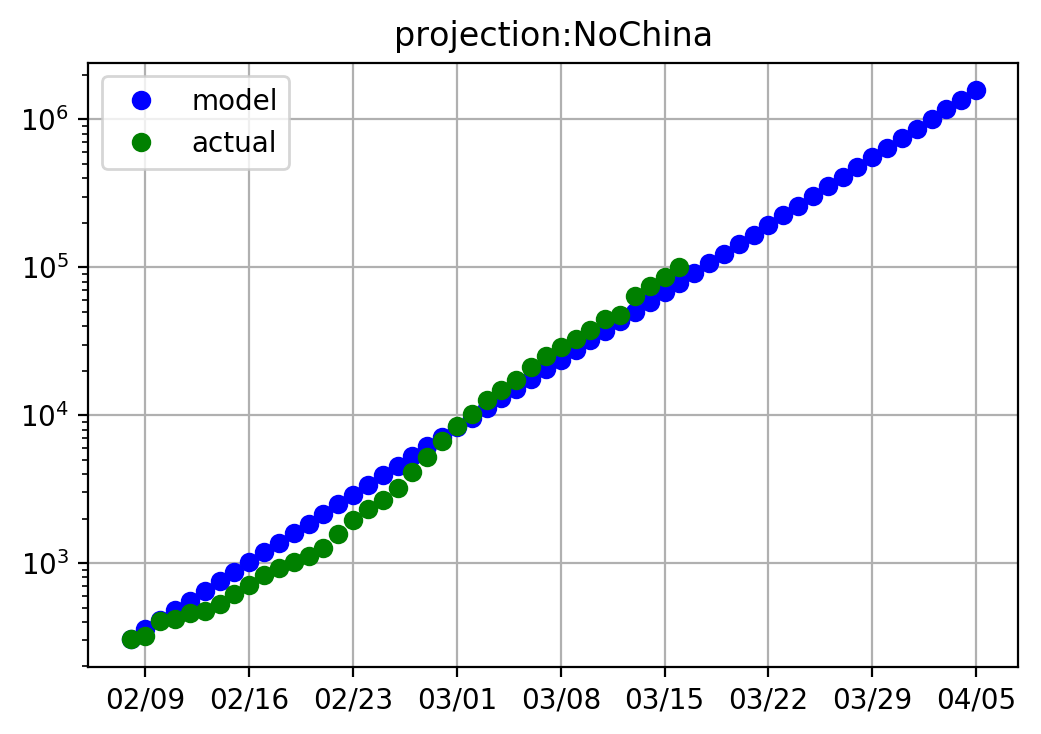

In [460]:
# try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# https://en.wikipedia.org/wiki/Generalised_logistic_function
# assuming a groth rate of 10%
#where will the us be
#start date
rate      = .15
ctr       = "NoChina"
caseMin   = 300
TN        = 21     # number of intervals after today



s = data.loc[ctr].sum()
startDate = s[s>caseMin].index[0]

print(startDate)

#nmber of intervals
N  = sp.size(data.columns)


# Set the epoch value
Y0 = data[startDate][ctr].sum()
#determine time offset
offset = (data.columns[-1]-startDate).days
Yt =Y0 * sp.exp(rate * np.arange(0,offset + TN))

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,offset + TN)]
NE = (datetime.datetime.today()-data.columns[-1] ).days


fig,ax = plt.subplots(1,1)
ax.plot_date(x,
             Yt,
             label="model")



ax.plot_date(x[:(offset+NE)],
             data.loc[ctr,startDate:].sum(),
             label="actual")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("projection:%s"%ctr)
#ax.set_ylim(0, 50000)
plt.yscale('log')



             model     cdc     jhu
2020-02-26    1302   260.5    57.0
2020-02-27    1468   296.5    58.0
2020-02-28    1655   349.5    60.0
2020-02-29    1866   399.5    68.0
2020-03-01    2104   473.5    74.0
2020-03-02    2373   549.5    98.0
2020-03-03    2675   634.5   118.0
2020-03-04    3017   724.5   149.0
2020-03-05    3401   802.5   217.0
2020-03-06    3835   879.5   262.0
2020-03-07    4324   948.5   402.0
2020-03-08    4875  1035.5   518.0
2020-03-09    5497  1148.5   583.0
2020-03-10    6198  1228.5   959.0
2020-03-11    6988  1278.5  1281.0
2020-03-12    7879  1300.5  1663.0
2020-03-13    8884  1314.5  2179.0
2020-03-14   10017  1317.5  2727.0
2020-03-15   11294  1320.5  3499.0
2020-03-16   12734  1323.5  4632.0
2020-03-17   14357     NaN     NaN
2020-03-18   16188     NaN     NaN
2020-03-19   18252     NaN     NaN
2020-03-20   20579     NaN     NaN
2020-03-21   23203     NaN     NaN
2020-03-22   26161     NaN     NaN
2020-03-23   29496     NaN     NaN
2020-03-24   33257  

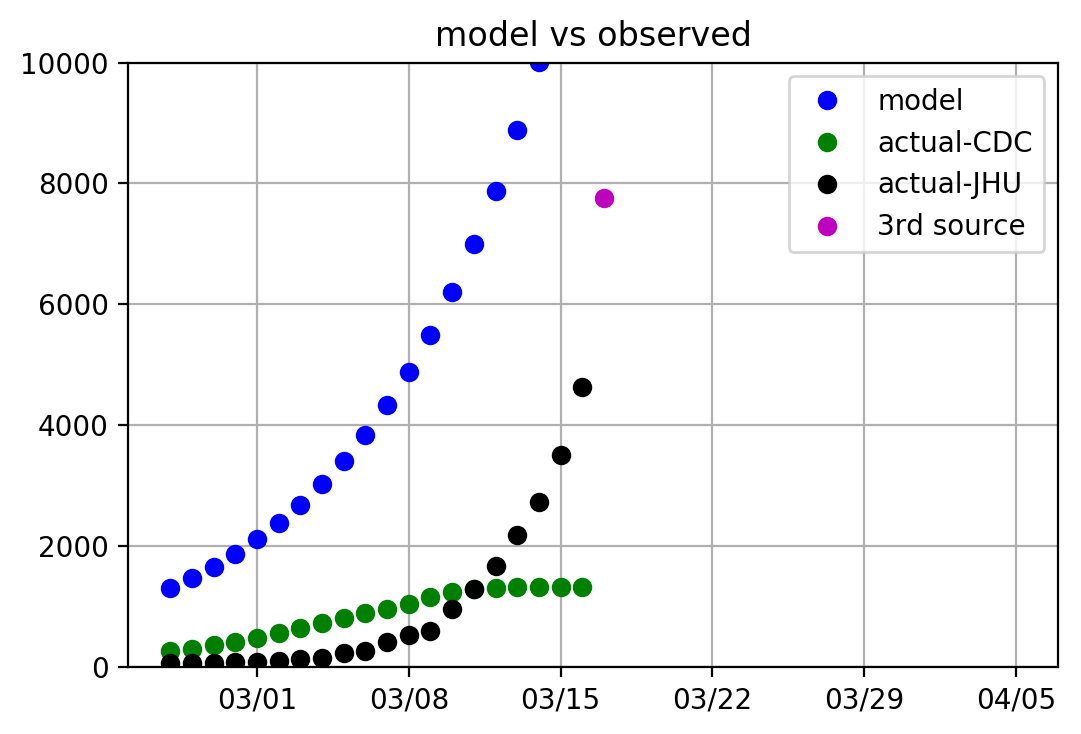

In [427]:
 #try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# use JHU
# estimate US data

idx = pd.IndexSlice

#find cumulateive greater then 50, this will be y0
startDate = dataCdc[dataCdc>250].index[0]
rate = .12

#start from scratch take y[0] and assume X% groth and assume, y0 was 20% report of all reporting (multiply by 5)
# get number of samples in the data base
N = (datetime.date.today()-startDate).days

#project for another 2 week
NP = 20
NEC = (datetime.date.today()    -dataCdc.index[-1]).days-1
NEJ = (datetime.datetime.today()-data.columns[-1] ).days-1


# projection (assume multipler of 5)
yh = dataCdc[startDate] * 5 * np.exp(rate * np.arange(0,N+NP))
yh=yh.astype(int)

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)

ax.plot_date(x,
             yh,
             label="model")
ax.plot_date(x[0:(N-NEC)],
             dataCdc[startDate:].values,
             label="actual-CDC")
ax.plot_date(x[0:(N-NEJ)],
             data.loc["US",startDate:].sum().values,
             label="actual-JHU")
ax.plot_date(datetime.date.today(),
             dataCS.loc[idx[:, :, :, "USA"],"cases"].sum(),
            label="3rd source")

ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("model vs observed")
ax.set_ylim(0, 10000)


yc = np.concatenate([dataCdc.loc[startDate:].values,
                     np.nan * np.ones(NP+NEC)])


yj = np.concatenate([data.loc["US",startDate:].sum().values,
                    np.nan * np.ones(NP+NEJ)])


if(1):
    df =pd.DataFrame({"model": yh,
                  "cdc"  : yc,
                  "jhu"  : yj},index=x)
    #this is wrong
    #df.loc[datetime.date.today(),"3rd"] = dataCS.loc[idx[:, :, :, "USA"],"cases"].sum()
    print(df)






In [497]:
import io
def get_csv_from_url(link):
    response = requests.get(link)
    
    file_object = io.StringIO(response.content.decode('utf-8'))
    return pd.read_csv(file_object)
    

# us daily data -->
links=\
 ["https://covidtracking.com/api/us.csv",      # US current
 "http://covidtracking.com/api/us/daily.csv", # time series  
 "https://covidtracking.com/api/states.csv",         ]# current

# how to get state data time series -->
# "https://covidtracking.com/api/states/daily?state=CA",#states
# "https://covidtracking.com/api/states/daily?state=NY",
df = get_csv_from_url(links[0]);display(HTML(df.to_html()))
df = get_csv_from_url(links[1]);display(HTML(df.sort_values(by="date",ascending=False).head(5).to_html()))
df = get_csv_from_url(links[2]);display(HTML(df.sort_values(by="positive",ascending=False).head(5).to_html()))



,positive,negative,posNeg,pending,death,total
0,5740,47645,53385,815,90,54202


,date,states,positive,negative,posNeg,pending,death,total
13,20200317,56,5723,47547,53270,815,90.0,54087
12,20200316,56,4019,35840,39859,1691,71.0,41552
11,20200315,51,3173,22548,25721,2242,60.0,27963
10,20200314,51,2450,17107,19557,1236,49.0,20795
9,20200313,51,1922,13513,15435,1130,39.0,16565


,state,positive,negative,pending,death,total,lastUpdateEt,checkTimeEt
37,NY,1700,5506.0,NaN,7.0,7206,3/16 15:00,3/17 15:15
52,WA,904,11582.0,NaN,48.0,12486,3/16 18:45,3/17 16:01
5,CA,483,7924.0,NaN,11.0,8407,3/16 21:00,3/17 15:15
34,NJ,267,163.0,55.0,3.0,485,3/17 13:00,3/17 15:35
21,MA,218,1541.0,NaN,NaN,1759,3/16 16:00,3/17 16:19


In [429]:
#script for scraping HTML sites but does not work on java scripts, need to inspect and find source
import requests
try:
    from bs4 import BeautifulSoup
except ImportError:
    !pip install packaging
    from bs4 import BeautifulSoup


URL = 'https://covidtracking.com/data/'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
#notes on soup are here: https://realpython.com/beautiful-soup-web-scraper-python/
#print(soup.prettify())
#soup.find("us-totals")



